In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tifffile

In [19]:
data_path = Path("../scripts/data/csv_files")
save_path = Path("./output")
dfs = [pd.read_csv(f) for f in data_path.glob("*.csv")]

df = dfs[0]

In [9]:
def numpify_df(events_df):
    dtype = np.dtype([('x', 'i4'), ('y', 'i4'), ('t', 'i8'), ('p', 'i1')])

    events = np.zeros(len(events_df), dtype=dtype)
    events['x'] = events_df['x'].to_numpy()
    events['y'] = events_df['y'].to_numpy()
    events['t'] = events_df['t'].to_numpy()
    events['p'] = events_df['p'].to_numpy()
    return events

def basic_event_iterator(events, t_step, t_window):
    """
    Basic event iterator that yields events in time windows.
    Moves the center of the window by t_step each iteration.
    Collects events within t_window/2 before and after the center time.
    """

    start_time = events['t'].min()
    end_time = events['t'].max()

    center_times = np.arange(start_time, end_time, t_step)
    for center_time in center_times:
        window_start = center_time - t_window / 2
        window_end = center_time + t_window / 2

        mask = (events['t'] >= window_start) & (events['t'] < window_end)
        yield events[mask]

def collapse_2d(events, shape):
    """
    Collapse events into a 2D histogram based on x and y coordinates.
    """
    img = np.zeros(shape, dtype=np.int32)
    for event in events:
        img[event['y'], event['x']] += 1
    return img


1279 719
56565


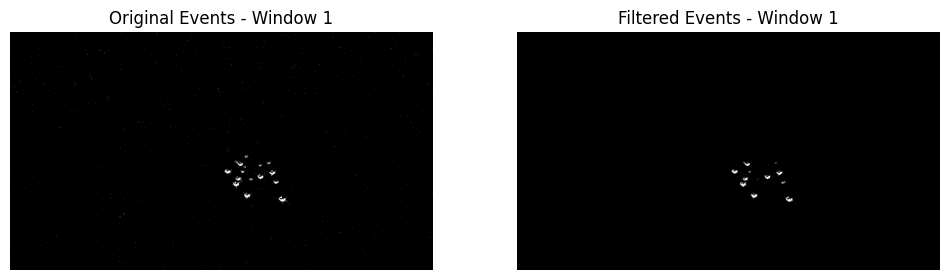

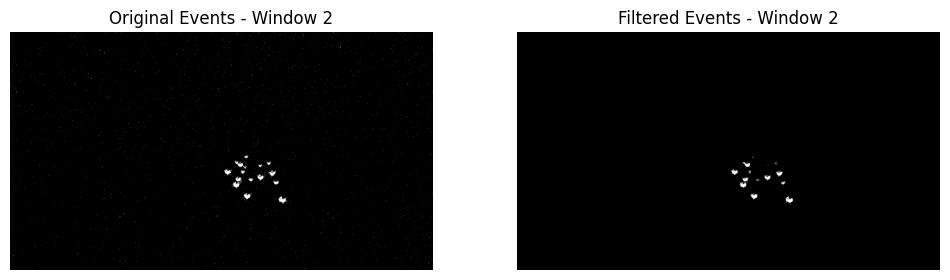

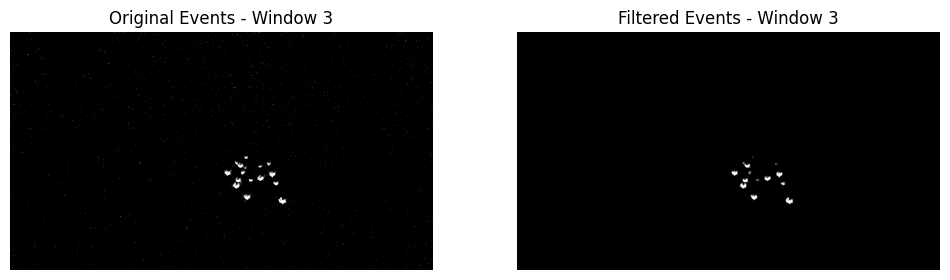

In [22]:
from eventcamprocessing import filter_funcs

events = numpify_df(df)

print(events["x"].max(), events["y"].max())
print(events["t"].max())

t_step = 10000  # in microseconds
t_window = 20000  # in microseconds
shape = (720, 1280)

for i, window_events in enumerate(basic_event_iterator(events, t_step, t_window)):
    if i >= 3:
        break

    window_events = window_events[window_events["p"] == 1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original collapsed image
    img_original = collapse_2d(window_events, shape) > 0

    # Filtered events
    filtered_events = filter_funcs.isolated_noise_filter(window_events, spatial_radius=5, time_window=500, min_neighbors=5)
    img_filtered = collapse_2d(filtered_events, shape) > 0

    # Plot original
    axes[0].imshow(img_original, cmap='gray')
    axes[0].set_title(f'Original Events - Window {i+1}')
    axes[0].axis('off')

    # Plot filtered
    axes[1].imshow(img_filtered, cmap='gray')
    axes[1].set_title(f'Filtered Events - Window {i+1}')
    axes[1].axis('off')

    stacked = np.hstack((img_original, img_filtered))
    tifffile.imwrite(save_path / f'filtered_events_window_{i+1}.tif', stacked.astype(np.uint8))

    plt.show()